# Tutorial for monocular depth estimation (2D to 3D) with pre-trained DINOv2 model

In [1]:
# Róisín Luo

#References:
#Paper: Vision Transformers for Dense Prediction
#       https://arxiv.org/pdf/2103.13413.pdf
#Paper: DINOv2

# Importing libraries

In [1]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [2]:
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"]

'1'

In [3]:
import sys
import os
import random
import math

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from atomicwrites import atomic_write #we must guarantee the automicity of write operation.
import pickle

#from tqdm.notebook import trange, tqdm
#from tqdm.contrib import tzip
#from tqdm.autonotebook import tqdm
from tqdm import tqdm

import csv
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision.utils import make_grid
import torchvision

from PIL import Image

%matplotlib inline

# GPU acceleration

In [4]:
def get_hwacc_device_v3():

    device = torch.device('cpu')
    
    if torch.cuda.is_available():
        
        print(torch.cuda.get_device_name(0))
        print('CUDA memory Usage:')
        print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
        print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    
        device = torch.device('cuda')
    # MacOS
    elif hasattr(torch, "backends") and \
          hasattr(torch.backends, "mps") and \
          torch.backends.mps.is_available():
                
        device = torch.device('mps')
 
    print("GPU device is: ", device)
    
    return device

In [5]:
device = get_hwacc_device_v3()
#device = torch.device("cpu")
device

GPU device is:  mps


device(type='mps')

# Loading depth estimation dataset

In [6]:
from datasets import list_datasets

datasets_list = list_datasets()
len(datasets_list)

36501

In [6]:
for ds in datasets_list:
    if "depth" in ds:
        print(ds)

kingabzpro/savtadepth-flags
kingabzpro/savtadepth-flags-V2
svnfs/depth-of-field
Beyza/depthmap
sakun/facedepth
sayakpaul/nyu_depth_v2
erkam/clevr-with-depth
erkam/clevr-with-depth-full
nev/diverse-depth
erkam/clevr-with-depth-full-v2
gligen/cc3m_tsv_depth


In [7]:
from datasets import load_dataset
import os

dataset = load_dataset(path = "sayakpaul/nyu_depth_v2",
                       cache_dir = ".." + os.sep + 
                                   ".." + os.sep + 
                                   ".." + os.sep + "Dataset_Collection", 
                       #download_mode = "reuse_dataset_if_exists"
                      )

Found cached dataset nyu_depth_v2 (/Users/roisinjiaolinluo/Documents/Research/AI_Research/Roisins_Tutorials_on_DL_Applications/Monocular_Depth_Estimation_with_pre-trained_DINOv2/../../../Dataset_Collection/sayakpaul___nyu_depth_v2/default/1.0.0/80157dc55fc37d154eb8157db00139028820c686cd2955a43a1d3850e315c383)


  0%|          | 0/2 [00:00<?, ?it/s]

## Investigating dataset

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'depth_map'],
        num_rows: 47584
    })
    validation: Dataset({
        features: ['image', 'depth_map'],
        num_rows: 654
    })
})

## Setting dataset and splitting dataset

In [9]:
#Setting format to torch or tensorflow
dataset.set_format(type='torch', columns=['image', 'depth_map'])

In [10]:
dataset_train_ = dataset['train']
dataset_val_ = dataset['validation']

In [11]:
image = dataset_train_[0]['image']

In [12]:
image.shape

torch.Size([480, 640, 3])

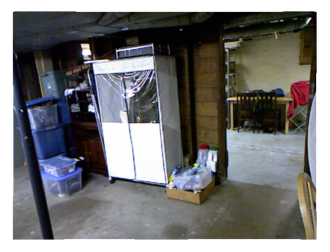

In [13]:
plt.figure(figsize=(4,4))
plt.imshow(image.numpy())
plt.axis('off')
plt.show()

In [13]:
d_max_list = []
for i in tqdm(range(1000)):
    depth = dataset_train_[0]['depth_map']
    d_max = torch.max(depth).numpy()
    d_max_list.append(d_max)

print("d_max = ", np.max(d_max_list))

100%|█████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:11<00:00, 83.97it/s]

d_max =  6.6245503


In [245]:
depth = dataset_train_[0]['depth_map']

In [246]:
depth.shape

torch.Size([480, 640])

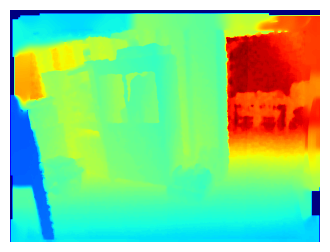

In [247]:
plt.figure(figsize=(4,4))
plt.imshow(depth.detach().numpy() / 6.6, cmap = "jet")
plt.axis('off')
plt.show()

In [248]:
def colored_depthmap(depth, d_min=None, d_max=None):
    cmap = plt.cm.viridis
    if d_min is None:
        d_min = np.min(depth)
    if d_max is None:
        d_max = np.max(depth)
    depth_relative = (depth - d_min) / (d_max - d_min)
    return 255 * cmap(depth_relative)[:,:,:3] # H, W, C

In [249]:
depth = colored_depthmap(depth.numpy())

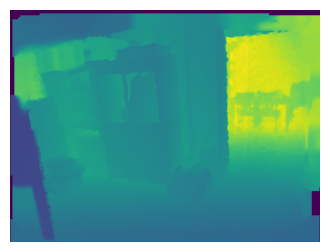

In [250]:
plt.figure(figsize=(4,4))
plt.imshow(depth / 255)
plt.axis('off')
plt.show()

# Wrapping the dataset

In [14]:
class DepthEstimationDataset(torch.utils.data.Dataset):
    def __init__(self, 
                 dataset, 
                 image_size = (224, 224),
                 random_seed = 42):
        
        self.dataset = dataset
        self.dataset_size = len(dataset)
        self.image_size = image_size
        self.transforms = torchvision.transforms.Compose([
                        torchvision.transforms.Resize(image_size)
        ])
        self.d_min = 0
        self.d_max = 6.7
        
        #self.dataset_indices = list(np.arange(0, self.dataset_size))
        
        np.random.seed(random_seed)
        
    def __getitem__(self, index):
        image = self.dataset[index]['image']
        image = image / 255.
        
        depth = self.dataset[index]['depth_map']
        depth = (depth - self.d_min) / (self.d_max - self.d_min)
        
        #WxHxC --> CxWxH
        image = image.permute(2, 0, 1)
        image = self.transforms(image)
        
        ##WxH --> 1x1xWxH
        depth = depth.unsqueeze(0)
        depth = self.transforms(depth)     
        depth = depth.squeeze(0)
        
        #We convert depth estimation problem into a classification problem.
        depth = depth.clip(0, 1) * 255
        depth = depth.long()
        
        return image, depth
    
    def __len__(self):
        return self.dataset_size

In [15]:
dataset_train = DepthEstimationDataset(dataset_train_)
dataset_val = DepthEstimationDataset(dataset_val_)

In [16]:
image, depth = dataset_train[0]

/opt/homebrew/Caskroom/miniconda/base/envs/research-py311/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [17]:
image.shape

torch.Size([3, 224, 224])

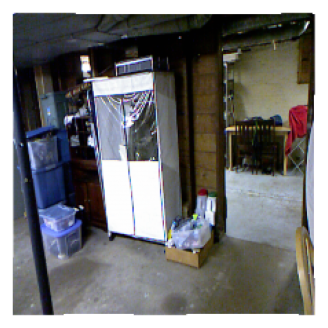

In [18]:
plt.figure(figsize=(4,4))
plt.imshow(image.permute(1,2,0).numpy())
plt.axis('off')
plt.show()

In [19]:
depth.shape

torch.Size([224, 224])

In [20]:
depth

tensor([[ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        [ 0,  0,  0,  ...,  0,  0,  0],
        ...,
        [80, 87, 87,  ..., 85, 85, 78],
        [80, 87, 87,  ..., 85, 85, 78],
        [80, 86, 87,  ..., 85, 85, 78]])

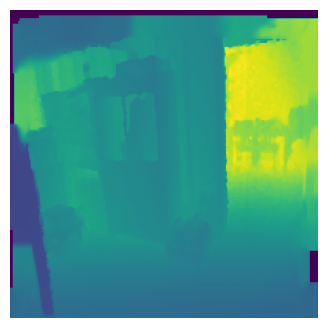

In [21]:
plt.figure(figsize=(4,4))
plt.imshow(depth / 255)
plt.axis('off')
plt.show()

In [22]:
batch_size = 32

In [23]:
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, shuffle=True)

In [24]:
image, depth = next(iter(dataloader_train))
image.shape

torch.Size([32, 3, 224, 224])

# Loading pre-trained DINOv2

In [25]:
dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
#dinov2_vitb14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')
#dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
#dinov2_vitg14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14')

Using cache found in /Users/roisinjiaolinluo/.cache/torch/hub/facebookresearch_dinov2_main
xFormers not available
xFormers not available


In [26]:
print(dinov2_vits14)

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

In [27]:
dinov2_vits14 = dinov2_vits14.to(device)
z = dinov2_vits14(torch.randn(10, 3, 224, 224).to(device))
z.shape

/opt/homebrew/Caskroom/miniconda/base/envs/research-py311/lib/python3.11/site-packages/torch/nn/functional.py:4018: UserWarning: The operator 'aten::upsample_bicubic2d.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  return torch._C._nn.upsample_bicubic2d(input, output_size, align_corners, scale_factors)


torch.Size([10, 384])

# Building 2D to 3D depth estimation model

In [28]:
class DepthEstimationModel(nn.Module):
    def __init__(self):
        
        super().__init__()
        
        self.device = device
    
        self.dinov2 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
        self.dinov2.eval() 
       
        #token to patch regressor.
        self.head = nn.Sequential(
                    #DINOv2 uses 14x14 as a patch
                    #For each pixel of a patch, we convert the depth estimation
                    #into a classification problem with 256 classes [0, ..., 255]
                    nn.Linear(in_features = 384, out_features = 14*14*256, bias = True),
                    )
            
    def forward(self, images):
        self.dinov2.eval()
        
        _, _, w, h = images.size()
        
        
        #we use layer 7.
        n_last_blocks_list=[7]
        
        #Extracting feature map from DINOv2.
        #Notice: Last layers may lose details and concentrate on
        #high-level semantic information.
        #Initial layers may focus on local semantic information while losing global 
        #information.
        #So, we choose a layer from the intermediate layers.
        with torch.no_grad():
            features = self.dinov2.get_intermediate_layers(images, 
                                                             n_last_blocks_list, 
                                                             return_class_token=True)
        
        #batch x num_tokens x 384
        tokens = features[0][0]
        #print("tokens.shape = ", tokens.shape)
        
        batch_size, num_tokens, _ = tokens.size()
        
        tokens = tokens.reshape(-1, 384)
        
        #stop gradients.
        tokens = tokens.detach()
        
        #print("tokens.shape = ", tokens.shape)
        #now, depth is (batch x num_tokens) x (14*14)
        depth_logits = self.head(tokens)
        
        depth_logits = depth_logits.reshape(batch_size, w, h, -1)
        
        #print("depth_logits.shape = ", depth_logits.shape)
        
        #the shape depth_logits is Bx224x224x256
        #torch.max() returns values, indices
        _, depth_preds = torch.max(depth_logits, dim = 3)
        #print("depth_preds.shape = ", depth_preds.shape)
        
        return depth_logits, depth_preds

In [29]:
model = DepthEstimationModel()

Using cache found in /Users/roisinjiaolinluo/.cache/torch/hub/facebookresearch_dinov2_main


In [30]:
x = dataset_train_[0]['image']
x = x.permute(2, 0, 1)
print(x.shape)
x = x.unsqueeze(0)
print(x.shape)
Resize = torchvision.transforms.Resize((224, 224))
x = Resize(x)
x = x / 255
print(x.shape)

torch.Size([3, 480, 640])
torch.Size([1, 3, 480, 640])
torch.Size([1, 3, 224, 224])


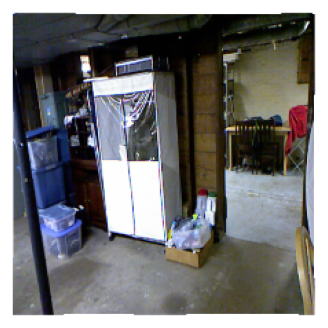

In [31]:
plt.figure(figsize=(4,4))
plt.imshow(x.squeeze(0).permute(1,2,0).numpy())
plt.axis('off')
plt.show()

In [32]:
depth_logits, depth_preds = model(x)
print(depth_logits.shape)
print(depth_preds.shape)

torch.Size([1, 224, 224, 256])
torch.Size([1, 224, 224])


# Training on epoch

In [53]:
%matplotlib inline

#from IPython.display import display, clear_output
from IPython import display

def train_one_epoch(
          model, 
          device, 
          dataloader, 
          optimizer, 
          criterion,
          epoch,
          display_per_batches = 10,
          axes = None,
          max_batches = None):
    
    # Enable gradient computing
    model.to(device)
    model.train()
    
    if max_batches is None:
        max_batches = len(dataloader)
    
    #some statistics
    
    #averaged loss in current epoch.
    epoch_loss = 0.0
    total_loss = 0.0
    
    #accuracy in current epoch
    batch_accuracy = 0.0
    #accuracy in current batch
    epoch_accuracy = 0.0
    
    #how many samples predicted correct.
    epoch_corrects = 0.0
    #how many samples trained in this epoch
    epoch_total = 0.0
    
    #batch_confidence = 0.0
    #epoch_confidence = 0.0
    
    for batch_idx, (images, depths) in enumerate(dataloader, 1):
        
        images = images.to(device)
        depths = depths.to(device)
        
        optimizer.zero_grad()
        
        #predictions.
        depth_logits, depth_preds = model(images)
        
        #computing CrossEntropy
        preds = depth_logits.reshape(-1, 256)
        labels = depths.flatten()
        
        loss = criterion(preds, labels)
           
        #computing gradients
        loss.backward()
        
        #optimizing the classifier, Notice: the GPT is fixed.
        optimizer.step()
        
        
        #computing accuracy in a batch
        # torch.max() returns values, indices
        _, preds_ = torch.max(preds, dim = 1)
        
        #computing the total loss and average loss in one epoch
        total_loss += loss.detach().cpu().numpy()
        epoch_loss = total_loss / batch_idx
        
        #computing the correct and total samples
        batch_corrects = torch.sum(labels.cpu().data == preds_.cpu().data, dtype = torch.int)
        batch_accuracy = batch_corrects / len(labels)
        epoch_corrects += batch_corrects
        epoch_total += len(labels)
        epoch_accuracy = epoch_corrects / epoch_total         

        """
        if True: #batch_idx % display_per_batches == 0:
            
            image = images[0].cpu().permute(1,2,0)
            depth = depth_preds[0].cpu()
            
            axes[0].imshow(image)
            axes[1].imshow(depth, cmap = "jet")
         
            
            axes[0].axis("off")
            axes[1].axis("off")
       
            
            axes[0].set_title(f"image")
            axes[1].set_title(f"depth")
         
            
            display.clear_output(wait=True)
            
            display.display(plt.gcf())
        """
        
        #Updating training displays.
        
        display.clear_output(wait=True)
        
        display.display('Epoch {} [{}/{} ({:.0f}%)]'.format(
                    epoch, batch_idx, 
                    len(dataloader), 
                    100. * (batch_idx / len(dataloader))))
        
        display.display('* batch accuracy {:.2f}% epoch accuracy {:.2f}%'.format(
                    100. * batch_accuracy, 100. * epoch_accuracy))
        
        display.display('* batch loss {:.6f} epoch loss {:.6f}'.format(
                    loss.item(), epoch_loss))
        display.display('* batch_corrects {}'.format(batch_corrects))
        
        
        
        if batch_idx > max_batches:
            break
    
    return epoch_loss, epoch_accuracy

In [54]:
model = DepthEstimationModel()
_ = model.to(device)

Using cache found in /Users/roisinjiaolinluo/.cache/torch/hub/facebookresearch_dinov2_main


In [55]:
#device = torch.device("cpu")

batch_size = 64

dataloader_train = torch.utils.data.DataLoader(dataset_train, 
                                               batch_size = batch_size, 
                                               shuffle=True)

learning_rate = 0.001

#for Adam. The learning rate 
#typically less than 0.001 for stabability.
optimizer = torch.optim.Adam(
                        model.head.parameters(), 
                        lr = learning_rate,
                        #momentum = 0.9, 
                        #weight_decay = 5e-4
                      )

#learning_rate = 0.01


#optimizer = torch.optim.SGD(
#                        model.head.parameters(), 
#                        lr = learning_rate,
                        #momentum = 0.9, 
                        #weight_decay = 5e-4
#                      )

#Loss function
criterion = torch.nn.CrossEntropyLoss()

RuntimeError: MPS backend out of memory (MPS allocated: 24.73 GB, other allocations: 5.48 GB, max allowed: 27.20 GB). Tried to allocate 3.06 GB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

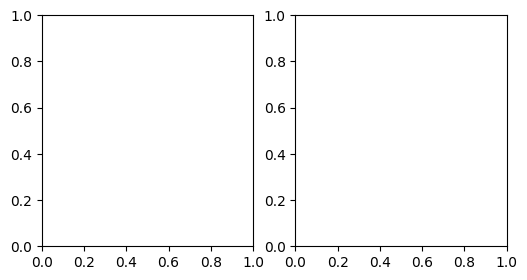

In [56]:
"""
ncols = 2
nrows = 1
subfig_width = 3
subfig_height = 3

figsize = (ncols * subfig_width, nrows * subfig_height)

fig, axes = plt.subplots(nrows = nrows,
                         ncols = ncols,
                         figsize = figsize)
"""
axes = None

epoch_loss, epoch_accuracy = train_one_epoch(
          model, 
          device, 
          dataloader_train, 
          optimizer, 
          criterion,
          epoch = 1,
          axes = axes,
          max_batches = 500)

In [38]:
x = dataset_train_[0]['image']
x = x.permute(2, 0, 1)
print(x.shape)
x = x.unsqueeze(0)
print(x.shape)
Resize = torchvision.transforms.Resize((224, 224))
x = Resize(x)
x = x / 255
print(x.shape)

torch.Size([3, 480, 640])
torch.Size([1, 3, 480, 640])
torch.Size([1, 3, 224, 224])


In [40]:
depth_logits, depth_preds = model(x.to(device))
print(depth_logits.shape)
print(depth_preds.shape)

torch.Size([1, 224, 224, 256])
torch.Size([1, 224, 224])


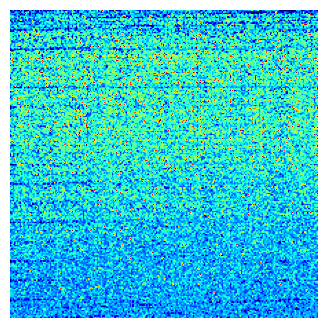

In [41]:
plt.figure(figsize=(4,4))
plt.imshow(depth_preds.squeeze(0).cpu().detach().numpy(), cmap = "jet")
plt.axis('off')
plt.show()

# Save/load model

In [217]:
import os

def save_model(model, model_path):
    
    save_path = os.path.normpath(os.path.dirname(model_path)).rstrip(os.path.sep)
        
    if not os.path.exists(save_path):
        os.makedirs(save_path)
        
    print("Save model weights to: ", model_path)
    torch.save(model.state_dict(), model_path)  

In [218]:
save_model(model, "models/model_depth_estimation_with_dinov2.pth")

Save model weights to:  models/model_depth_estimation_with_dinov2.pth


In [219]:
def load_model(model_path, device):
    model = DepthEstimationModel()
    
    if os.path.exists(model_path):
        #re-loading
        model.load_state_dict(torch.load(model_path, map_location = device)) 
        print("Loaded model weights from: ", model_path)
    else:
        print("Model weights not found.")
        
    return model

In [ ]:
model = load_model("models/model_depth_estimation_with_dinov2.pth", device)

# Complete training

In [221]:
def train(model, 
          device, 
          dataloader, 
          optimizer,
          criterion,
          epochs,
          scheduler = None):
    
    #if model_path is not None and not os.path.exists(model_path):
    #    os.makedirs(model_path)
    
    loss_hist = []
    accuracy_hist = []
    
    for epoch in range(1, epochs + 1):
        
        epoch_loss, epoch_accuracy = train_one_epoch(
          model, 
          device, 
          dataloader, 
          optimizer, 
          criterion,
          epoch,
          max_batches = None)
    
        if scheduler:
            #adjusting LR is necessary
            scheduler.step()
            
        loss_hist.append(epoch_loss)
        accuracy_hist.append(epoch_accuracy)
   
    return loss_hist, laccuracy_hist

In [223]:
batch_size = 64

dataloader_train = torch.utils.data.DataLoader(dataset_train, 
                                               batch_size=batch_size, 
                                               shuffle=True)

learning_rate = 0.001

#for language models, Adam is a good option.The learning rate 
#typically less than 0.001 for stabability.
optimizer = torch.optim.Adam(
                        model.head.parameters(), 
                        lr = learning_rate,
                        #momentum = 0.9, 
                        #weight_decay = 5e-4
                      )

#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 
#                                                step_size = 10, #dropping learning-rate every 10 steps. 
#                                                gamma = 0.1)
scheduler = None

#Loss function
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
loss_hist, laccuracy_hist = train(model, 
          device, 
          dataloader_train, 
          optimizer,
          criterion,
          epochs = 50,
          scheduler = scheduler)

In [ ]:
#plt.plot(loss_hist)

In [ ]:
#plt.plot(laccuracy_hist)